# Exploratory Data Analysis of WeightDataset

This notebook analyzes the structure and characteristics of the WeightDataset used in the autoencoder training. The dataset contains neural network weights that are used to train an autoencoder model.

In [ ]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from omegaconf import OmegaConf

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from dataset import WeightDataset

c:\Users\matze\anaconda3\envs\hyper-diffusion\lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")
c:\Users\matze\anaconda3\envs\hyper-diffusion\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## 1. Load Configuration and Dataset

Load the configuration and initialize the dataset with the same parameters used in training.

In [ ]:
cfg = OmegaConf.load('configs/default.yaml')

# Initialize dataset
dataset = WeightDataset(
    mlps_folder="../mlp_weights/3d_128_plane_multires_4_manifoldplus_slower_no_clipgrad",
    wandb_logger=None,
    model_dims=cfg.dataset.model_dims,
    mlp_kwargs=cfg.dataset.mlp_kwargs,
    cfg=cfg.dataset
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 4045


## 2. Analyze Sample Structure

In [9]:
# Get a few samples
samples = [dataset[i] for i in range(3)]

for i, (weights, weights_prev, _) in enumerate(samples):
    print(f"\nSample {i+1}:")
    print(f"Weights shape: {weights.shape}")
    print(f"Weights statistics:")
    print(f"  Mean: {weights.mean():.4f}")
    print(f"  Std: {weights.std():.4f}")
    print(f"  Min: {weights.min():.4f}")
    print(f"  Max: {weights.max():.4f}")


Sample 1:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1628
  Std: 0.9083
  Min: -18.7730
  Max: 10.6990

Sample 2:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1253
  Std: 0.7616
  Min: -12.4229
  Max: 7.2907

Sample 3:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1241
  Std: 0.8126
  Min: -15.2188
  Max: 7.0414


c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


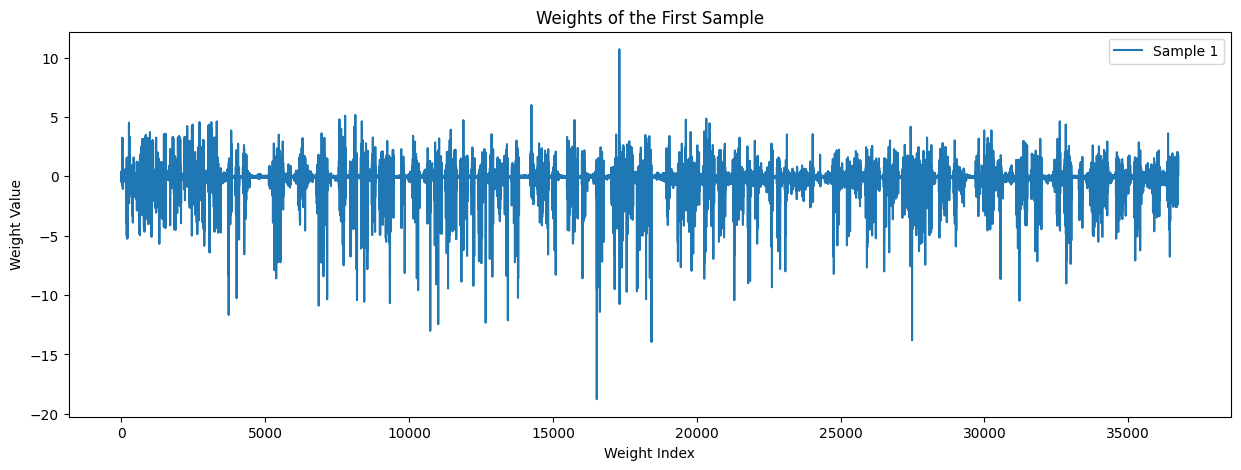

In [14]:
plt.figure(figsize=(15, 5))
for idx, (weights, _, _) in enumerate(samples[:1]):
    plt.plot(weights.numpy(), label=f'Sample {idx+1}')
plt.title('Weights of the First Sample')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

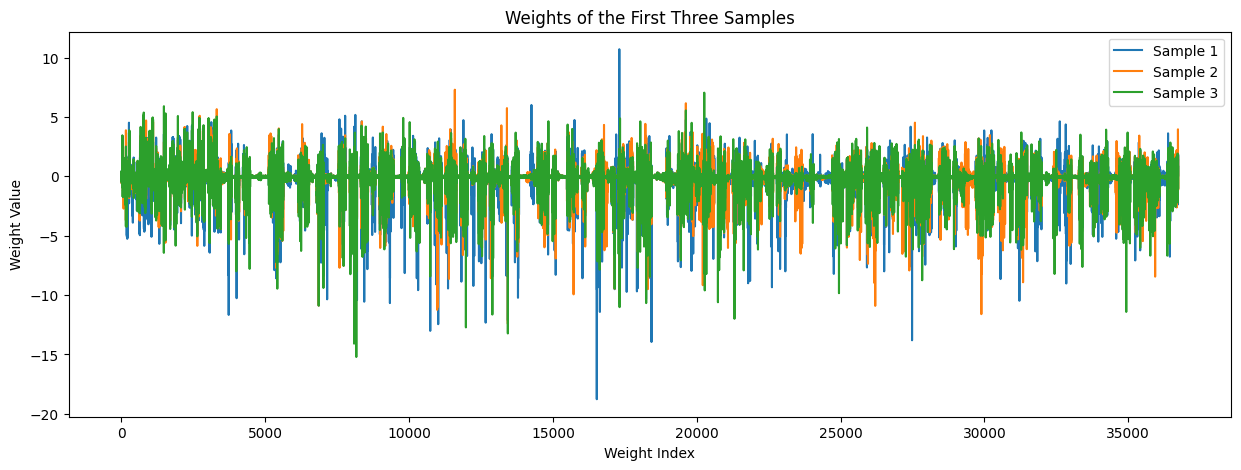

In [15]:
plt.figure(figsize=(15, 5))
for idx, (weights, _, _) in enumerate(samples):
    plt.plot(weights.numpy(), label=f'Sample {idx+1}')
plt.title('Weights of the First Three Samples')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

## 3. Distribution Analysis

Let's analyze the distribution of weights across multiple samples to understand their statistical properties.

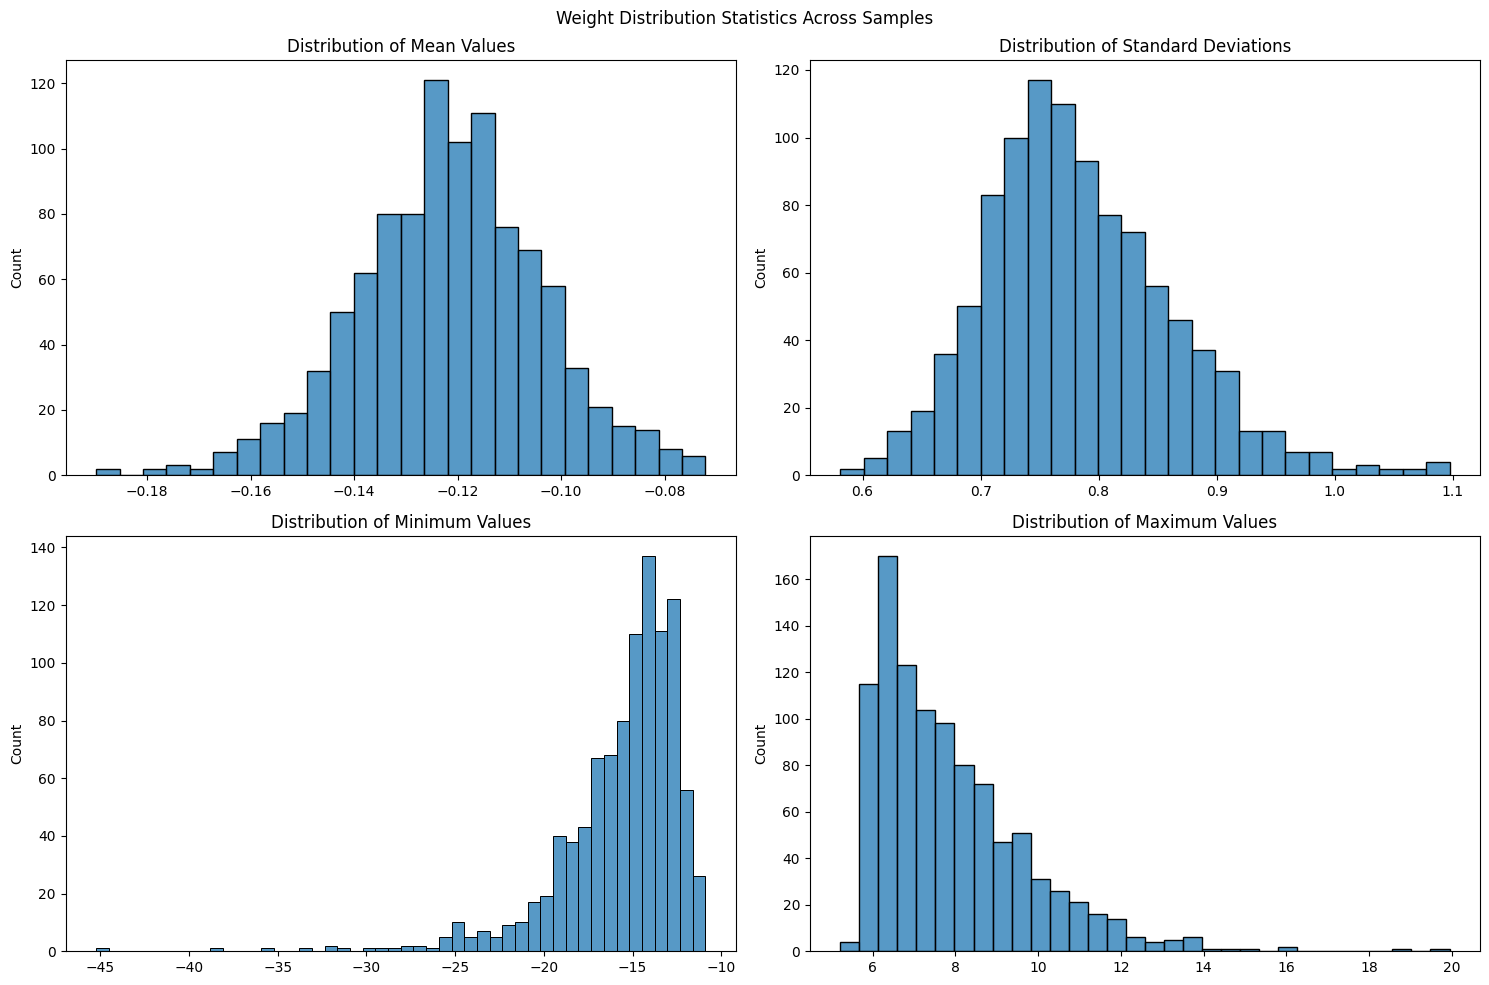

In [ ]:
def analyze_weight_distribution(dataset, n_samples=1000):
    # Collect statistics from multiple samples
    means = []
    stds = []
    mins = []
    maxs = []
    
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        means.append(weights.mean().item())
        stds.append(weights.std().item())
        mins.append(weights.min().item())
        maxs.append(weights.max().item())
    
    return means, stds, mins, maxs

means, stds, mins, maxs = analyze_weight_distribution(dataset)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Weight Distribution Statistics Across Samples')

sns.histplot(means, ax=axes[0,0])
axes[0,0].set_title('Distribution of Mean Values')ZZ

sns.histplot(stds, ax=axes[0,1])
axes[0,1].set_title('Distribution of Standard Deviations')

sns.histplot(mins, ax=axes[1,0])
axes[1,0].set_title('Distribution of Minimum Values')

sns.histplot(maxs, ax=axes[1,1])
axes[1,1].set_title('Distribution of Maximum Values')

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


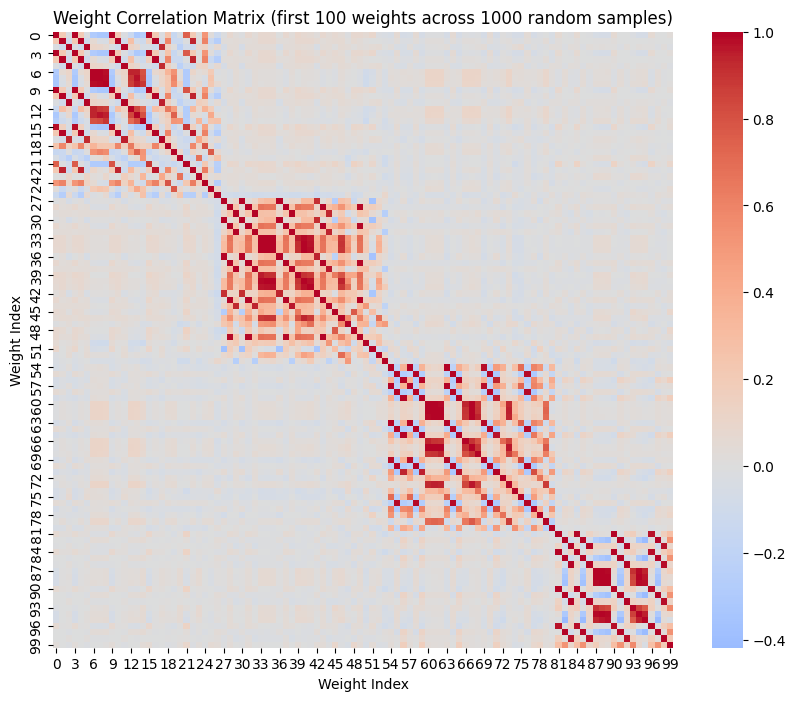

In [34]:
def analyze_weight_correlations(dataset, n_samples=5, n_weights=100, seed=42):
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)
    weight_list = []
    for i in indices:
        weights, _, _ = dataset[i]
        weight_list.append(weights.numpy()[:n_weights])
    weights_2d = np.stack(weight_list)

    corr_matrix = np.corrcoef(weights_2d, rowvar=False)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title(f'Weight Correlation Matrix (first {n_weights} weights across {n_samples} random samples)')
    plt.xlabel('Weight Index')
    plt.ylabel('Weight Index')
    plt.show()

# analyze_weight_correlations(dataset, n_samples=5, n_weights=100, seed=42)
analyze_weight_correlations(dataset, n_samples=1000, n_weights=100, seed=42)

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")
c:\U

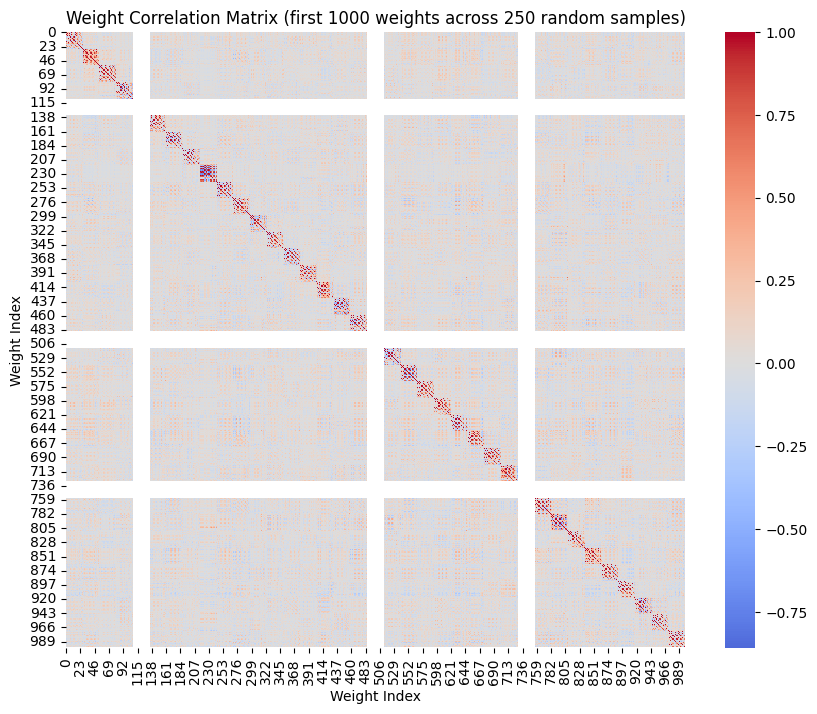

In [40]:
analyze_weight_correlations(dataset, n_samples=250, n_weights=1000, seed=42)

## 5. Dimensionality Analysis

Might make more sense when dataset are on different shapes (e.g. mixing chairs and planes)

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


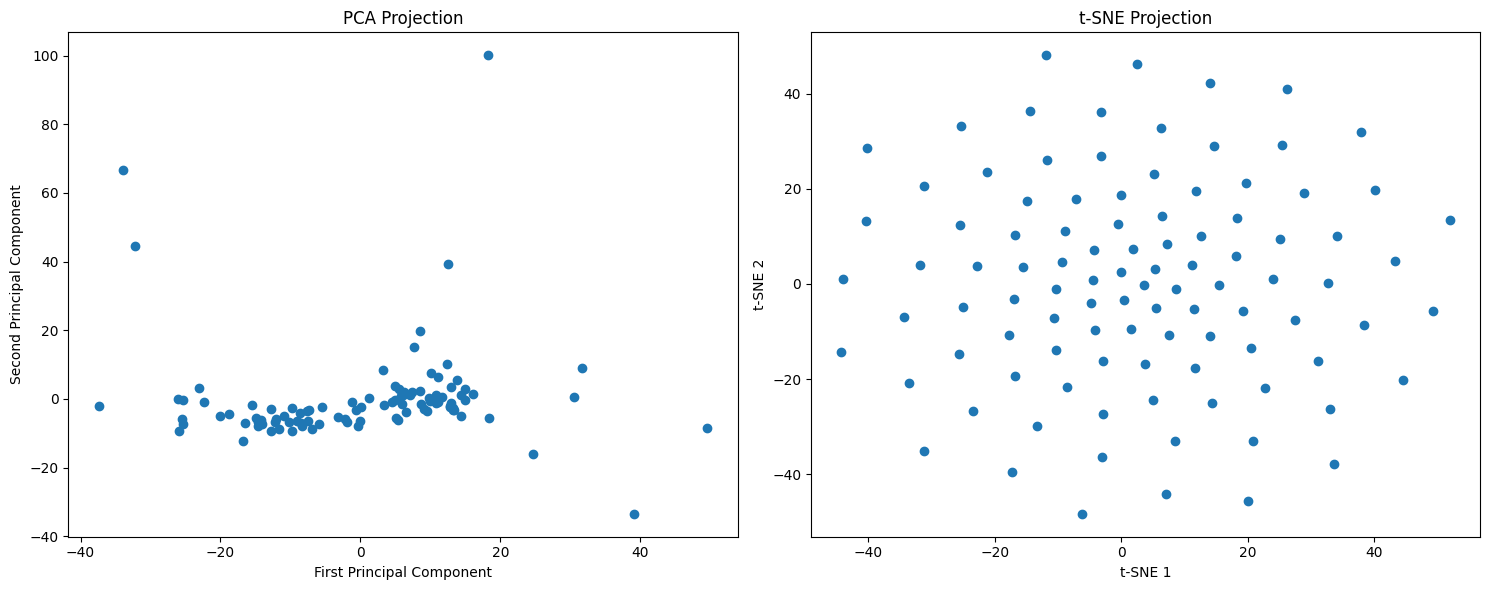

PCA explained variance ratio: [0.0213494  0.01966398]
Total explained variance: 0.0410


In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def analyze_dimensionality(dataset, n_samples=100):
    # Collect weight vectors
    weight_vectors = []
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        weight_vectors.append(weights.numpy())
    
    weight_vectors = np.array(weight_vectors)
    
    # PCA Analysis
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weight_vectors)
    
    # t-SNE Analysis
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(weight_vectors)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(pca_result[:, 0], pca_result[:, 1])
    ax1.set_title('PCA Projection')
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')
    
    ax2.scatter(tsne_result[:, 0], tsne_result[:, 1])
    ax2.set_title('t-SNE Projection')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

analyze_dimensionality(dataset)

## 6. Summary Statistics

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


Dataset Statistics:
Number of samples analyzed: 1000
Total number of weights: 36737000

Weight Statistics:
Mean: -0.1216
Std: 0.7879
Min: -45.2322
Max: 19.9485

Percentiles:
25th: -0.1400
50th: -0.0400
75th: 0.0520


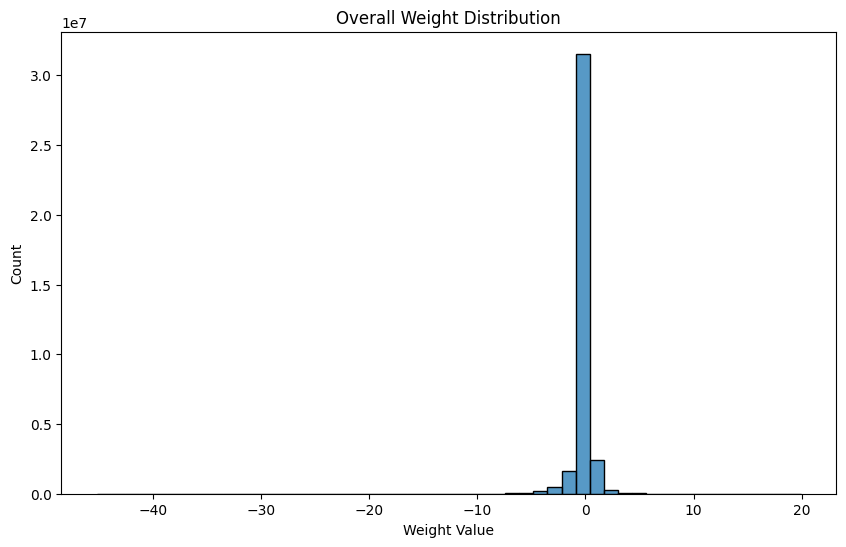

In [42]:
def compute_dataset_statistics(dataset, n_samples=1000):
    all_weights = []
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        all_weights.append(weights.numpy())
    
    all_weights = np.concatenate(all_weights)
    
    print("Dataset Statistics:")
    print(f"Number of samples analyzed: {n_samples}")
    print(f"Total number of weights: {len(all_weights)}")
    print(f"\nWeight Statistics:")
    print(f"Mean: {np.mean(all_weights):.4f}")
    print(f"Std: {np.std(all_weights):.4f}")
    print(f"Min: {np.min(all_weights):.4f}")
    print(f"Max: {np.max(all_weights):.4f}")
    print(f"\nPercentiles:")
    print(f"25th: {np.percentile(all_weights, 25):.4f}")
    print(f"50th: {np.percentile(all_weights, 50):.4f}")
    print(f"75th: {np.percentile(all_weights, 75):.4f}")
    
    # Plot overall distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(all_weights, bins=50)
    plt.title('Overall Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    plt.show()

compute_dataset_statistics(dataset)